# US Medical Insurance Exploration

In this notebook, we explore how common health variables may affect the charges in US medical insurance. We start by a quick exploration and organization of the data, then proceed to analyse how age and bmi affect such costs. In a third instance we use these two indices to model an expected cost for insurance.

## Basic ETL

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
import seaborn as sns

In [2]:
df = pd.read_csv("insurance.csv")
df.head()
df.smoker=df.smoker.replace('yes',1).replace("no",0)

In [3]:
df.describe()

,age,bmi,children,smoker,charges
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,0.204783,13270.422265
std,14.049960,6.098187,1.205493,0.403694,12110.011237
min,18.000000,15.960000,0.000000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,0.000000,9382.033000
75%,51.000000,34.693750,2.000000,0.000000,16639.912515
max,64.000000,53.130000,5.000000,1.000000,63770.428010


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   int64  
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 73.3+ KB


We see that there are no nan number nor outliers. The data is already clean.

In [5]:
df.corr().style.set_caption("General Correlation Table")

,age,bmi,children,smoker,charges
age,1.000000,0.109272,0.042469,-0.025019,0.299008
bmi,0.109272,1.000000,0.012759,0.003750,0.198341
children,0.042469,0.012759,1.000000,0.007673,0.067998
smoker,-0.025019,0.003750,0.007673,1.000000,0.787251
charges,0.299008,0.198341,0.067998,0.787251,1.000000


# Age modeling

Here we first vizualize and see the correlation between age other features. We start by a general plotting, then divide the sample into smokers and non-smokers.

In [6]:
df_age_groupby = df.groupby("age").mean()

array([<AxesSubplot:xlabel='age'>, <AxesSubplot:xlabel='age'>,
       <AxesSubplot:xlabel='age'>, <AxesSubplot:xlabel='age'>],
      dtype=object)

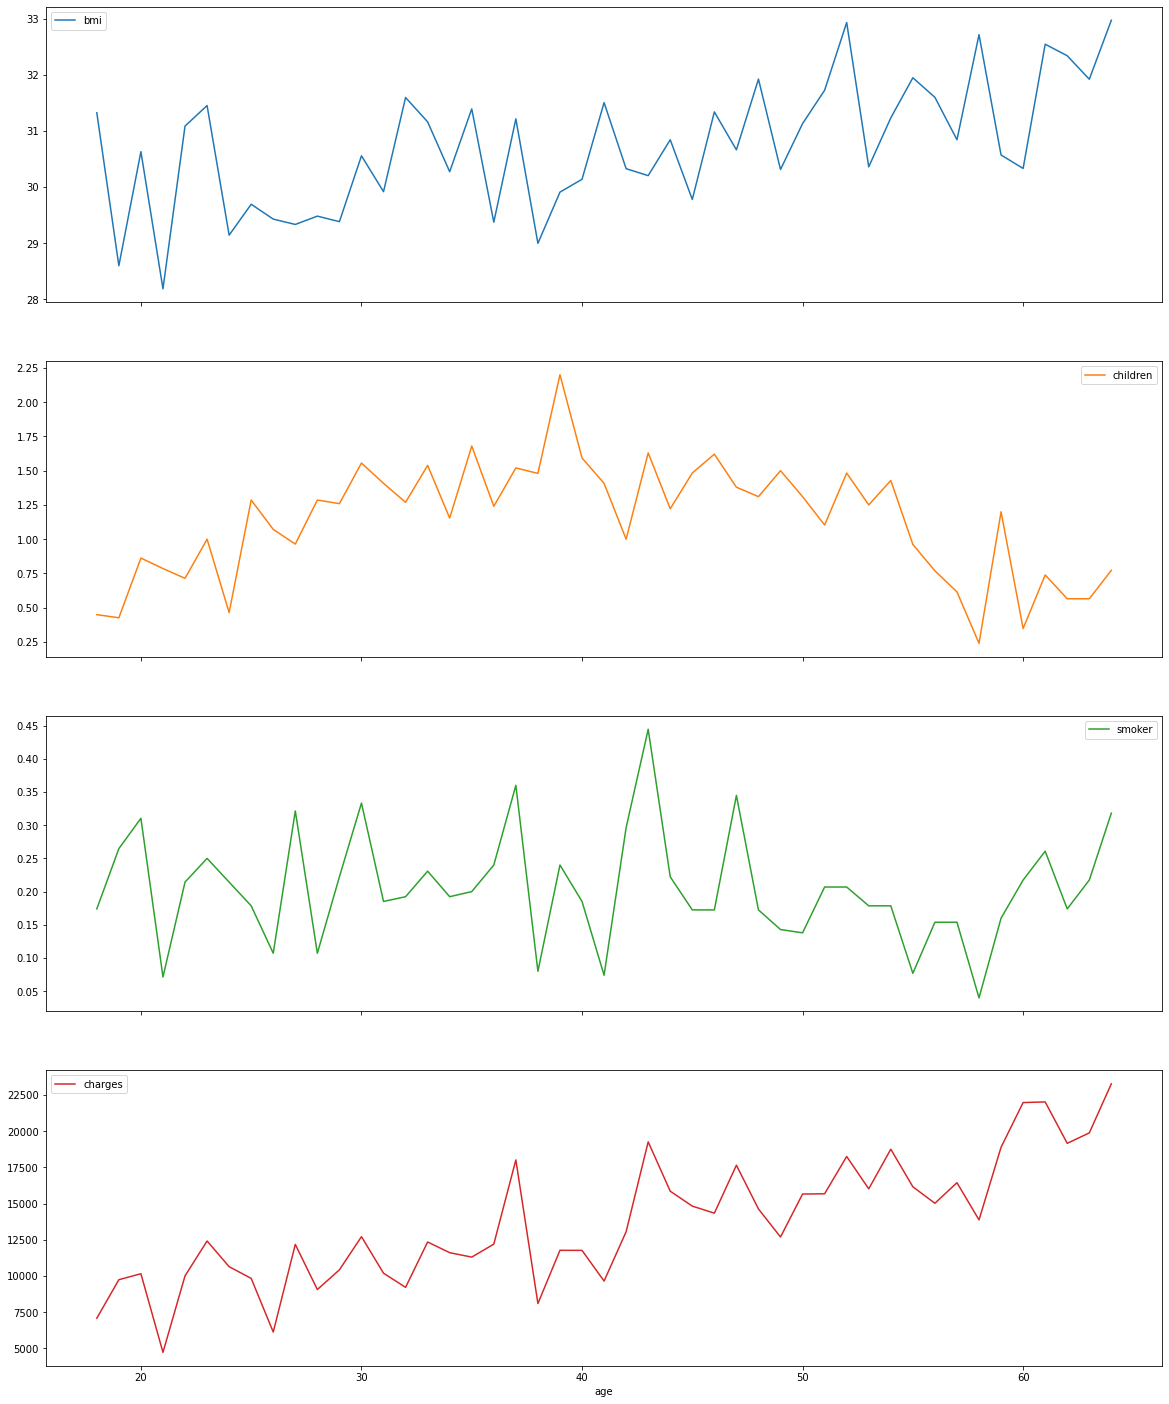

In [7]:
df_age_groupby.plot(subplots=True,figsize=(20,25))

array([<AxesSubplot:xlabel='age'>, <AxesSubplot:xlabel='age'>,
       <AxesSubplot:xlabel='age'>], dtype=object)

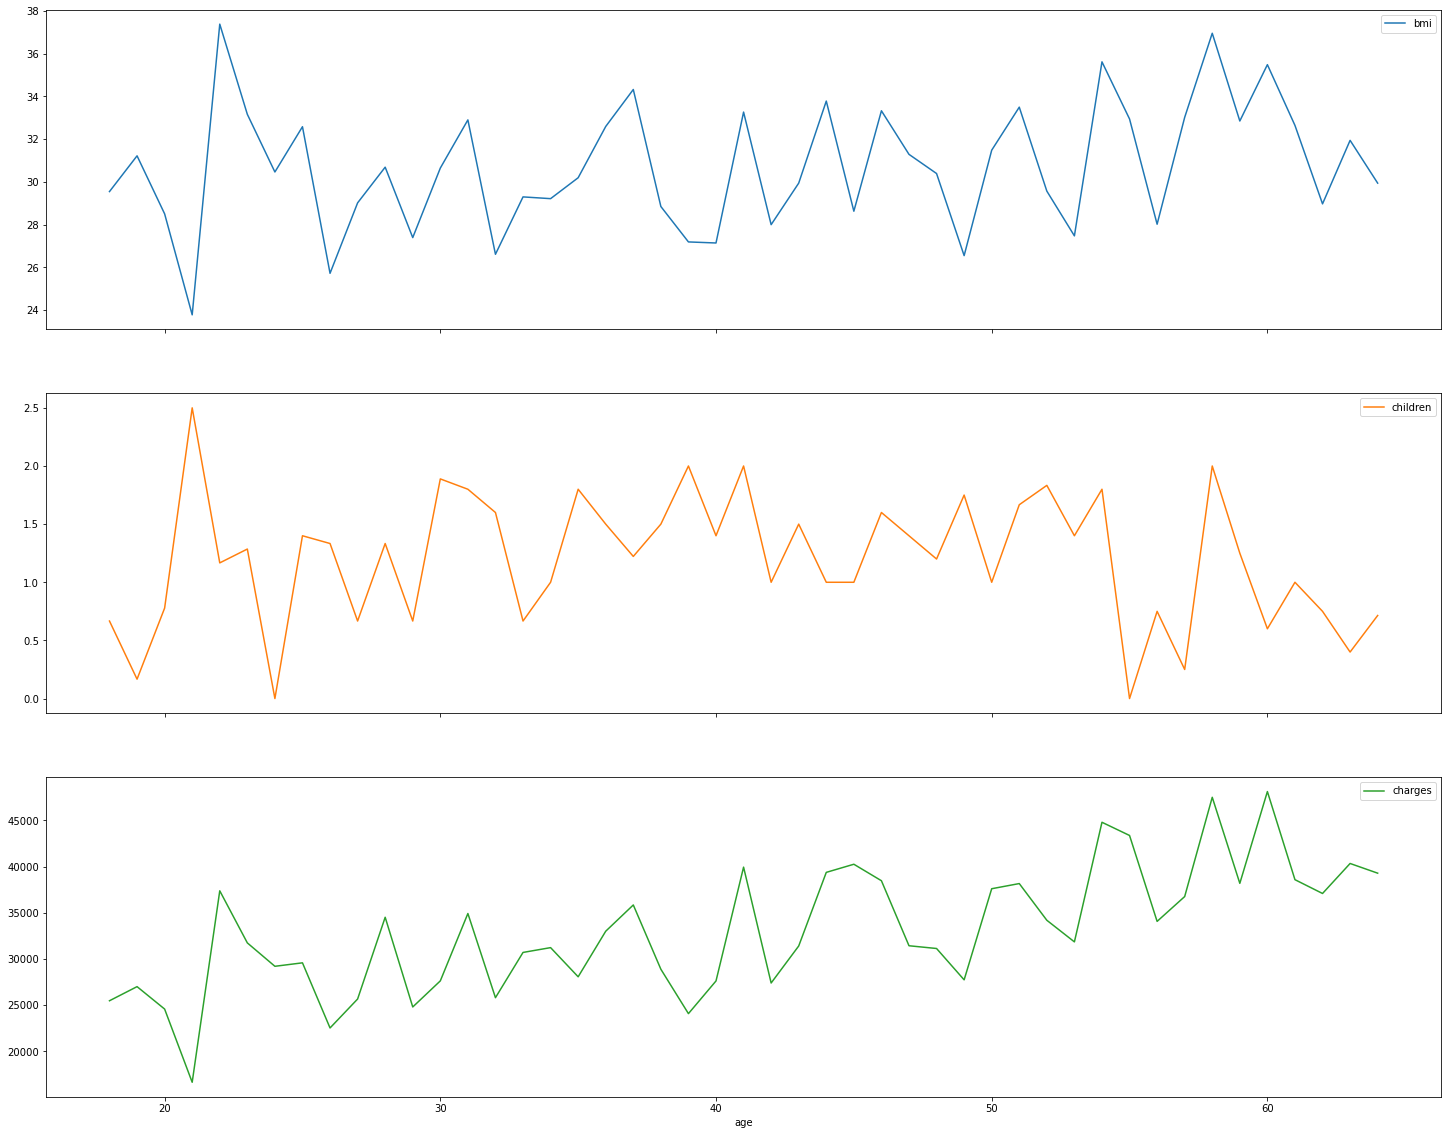

In [8]:
df_smokers = df[df.smoker==1].copy()
df_smokers.drop(columns=["smoker"],inplace=True);
df_age_smokers_groupby = df_smokers.groupby("age").mean()
df_age_smokers_groupby.plot(subplots=True,figsize=(25,20))

array([<AxesSubplot:xlabel='age'>, <AxesSubplot:xlabel='age'>,
       <AxesSubplot:xlabel='age'>], dtype=object)

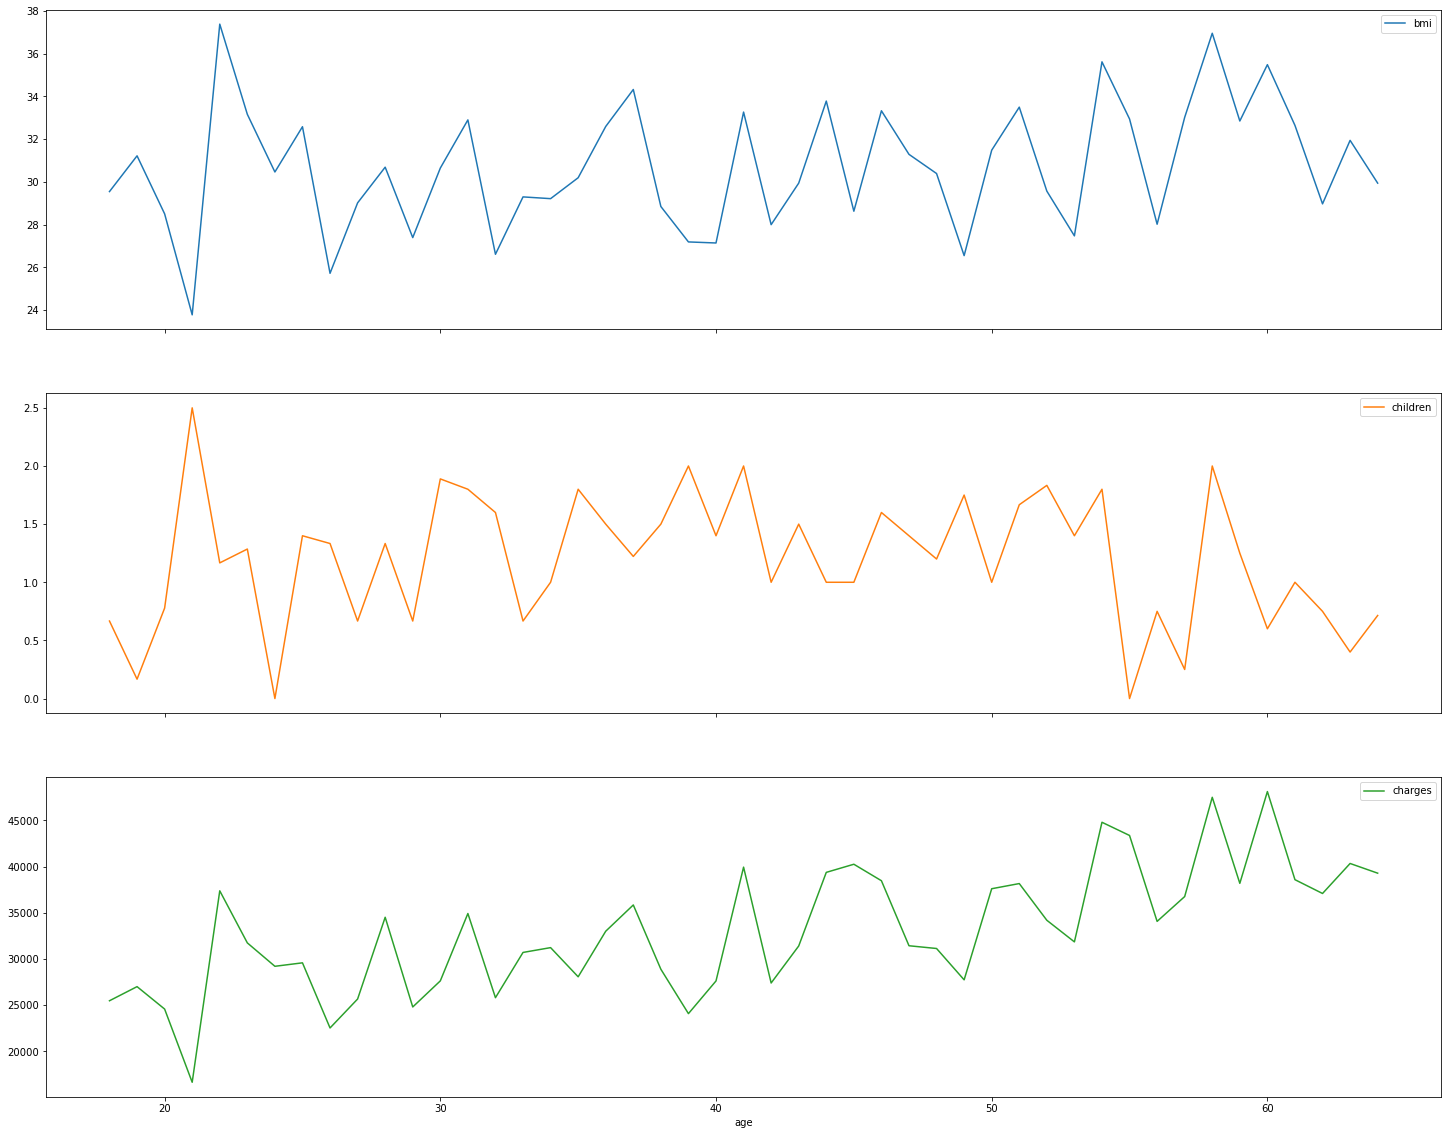

In [9]:
df_no_smokers = df[df.smoker==0].copy()
df_no_smokers.drop(columns=["smoker"],inplace=True)
df_age_no_smokers_groupby = df_smokers.groupby("age").mean()
df_age_no_smokers_groupby.plot(subplots=True,figsize=(25,20))

There is a clearer difference when we plot both groups together in a scatter plot.

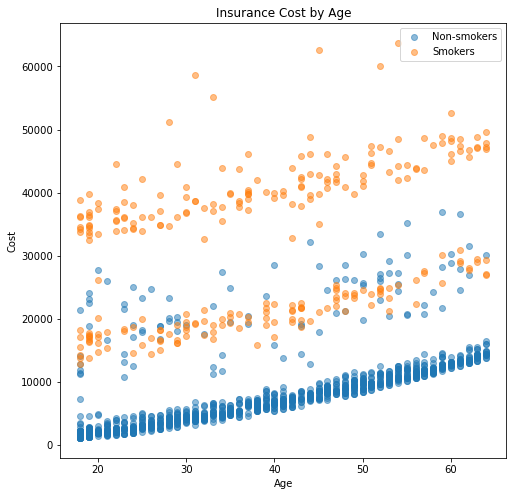

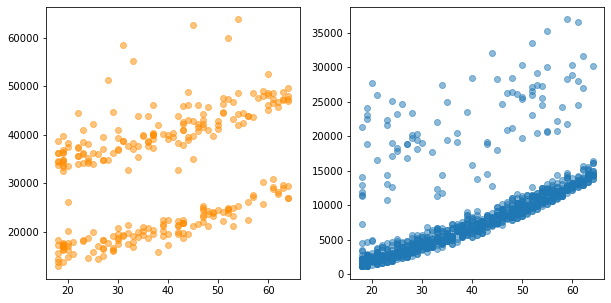

In [21]:
plt.figure(figsize=(8,8))
plt.scatter(df_no_smokers.age,df_no_smokers.charges,alpha=0.5)
plt.scatter(df_smokers.age,df_smokers.charges,alpha=0.5)

plt.legend(["Non-smokers", "Smokers"])
plt.xlabel("Age")
plt.ylabel("Cost")
plt.title("Insurance Cost by Age")

plt.show()

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(df_smokers.age,df_smokers.charges,alpha=0.5,color="darkorange")




plt.subplot(1,2,2)
plt.scatter(df_no_smokers.age,df_no_smokers.charges,alpha=0.5)


plt.show()



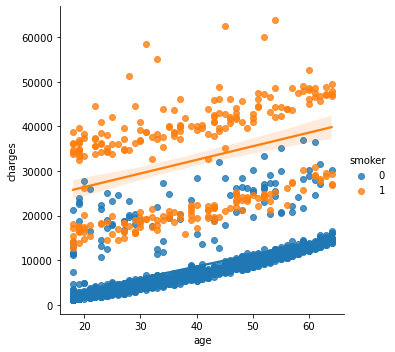

In [11]:
sns.lmplot(x = 'age', y = 'charges', hue = 'smoker', data = df)
plt.show()

We also look for some relation between age and bmi, without success.

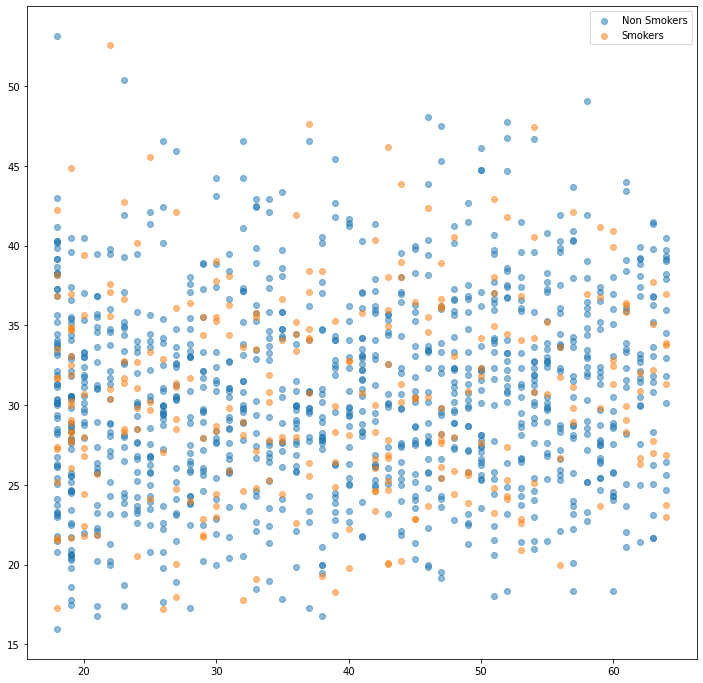

In [12]:
plt.figure(figsize=(12,12))
plt.scatter(df_no_smokers.age,df_no_smokers.bmi,alpha=0.5)
plt.scatter(df_smokers.age,df_smokers.bmi,alpha=0.5)
plt.legend(["Non Smokers","Smokers"])
plt.show()

In [13]:
stats.ttest_ind(df_smokers.charges,df_no_smokers.charges)

Ttest_indResult(statistic=46.66492117272371, pvalue=8.271435842179102e-283)

In [14]:
stats.ttest_ind(df_smokers.bmi,df_no_smokers.bmi)

Ttest_indResult(statistic=0.13708403310827058, pvalue=0.8909850280013041)

## Smokers by age

We take the opportunity to understand how the smoking population is distributed through ages. We specially divide the sample in three age groups, from where we conclude the data aquisition might be conduct in order to equally distribute the number of smokers and non-smokers. 

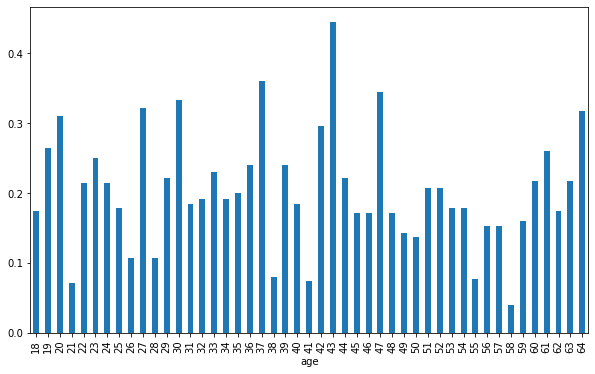

In [15]:
df_smoke_by_age = df.groupby("age").smoker.mean()
plt.figure(figsize=(10,6))
df_smoke_by_age.plot.bar()
plt.show()

Next we evaluate how is the distribution around age groups. We devide the sample in three age groups and apply a $\chi^2$-contingency test to understand how age might influence in smoking.

In [16]:
df_smoke_by_age = df.groupby(["age","smoker"]).sex.count().reset_index().set_index("smoker")

contingency = pd.merge(df_smoke_by_age.loc[0].reset_index().drop(columns=["smoker"]), 
df_smoke_by_age.loc[1].reset_index().drop(columns=["smoker"]), on="age")\
#     .rename(columns=["age","smokers","non_smokers"])
#     .drop(columns=["age"])

contingency.columns = ["age","smokers","non_smokers"]

def age_separator(x):
    if x <64/3:
        return "18-22"
    elif x < 2*64/3:
        return "23-44"
    else:
        return "44-64"

mask = contingency.age.apply(age_separator)

contingency = contingency.groupby(mask).count().drop(columns=["age"])

print(contingency)


print(f"\n The resulting p-value is: {stats.chi2_contingency(contingency)[1]}")

       smokers  non_smokers
age                        
18-22        4            4
23-44       21           21
44-64       22           22

 The resulting p-value is: 1.0


From this we conclude that the test might have been conducted in order to distribute the population equally between smokers and non-smokers.

# BMI comparison

Another question is how the BMI affects the current charges. Although not a necessarily required index when contracting the insurance, it shows very correlated with the charges in the smoking population. 

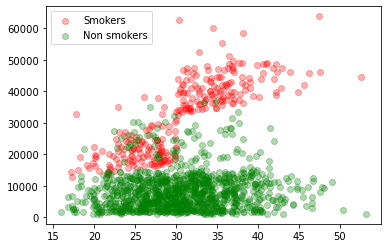

In [17]:
plt.scatter(df_smokers.bmi,df_smokers.charges,color="r",alpha=.3)
plt.scatter(df_no_smokers.bmi,df_no_smokers.charges,color="g",alpha=.3)
plt.legend(["Smokers","Non smokers"])

This graph does not gives us a clear vizualization since both plots require different scale. Let us break them into two.

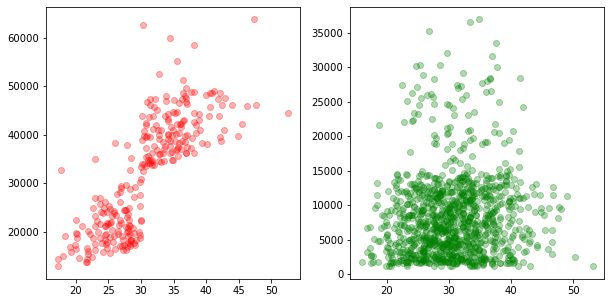

In [18]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(df_smokers.bmi,df_smokers.charges,color="r",alpha=.3)
plt.subplot(1,2,2)
plt.scatter(df_no_smokers.bmi,df_no_smokers.charges,color="g",alpha=.3)
plt.show()


It seems  bmi and  charges are greatly correlated whenever you smoke, but not otherwise. We can acertain this information by computing their Pearson Correlations.

In [19]:
df_smokers.corr().style.set_caption("Correlation Smoking Population")

,age,bmi,children,charges
age,1.000000,0.059674,0.081183,0.368224
bmi,0.059674,1.000000,-0.012619,0.806481
children,0.081183,-0.012619,1.000000,0.035945
charges,0.368224,0.806481,0.035945,1.000000


In [20]:
df_no_smokers.corr().style.set_caption("Correlation Non-smoking Population")

,age,bmi,children,charges
age,1.000000,0.122638,0.033395,0.627947
bmi,0.122638,1.000000,0.019208,0.084037
children,0.033395,0.019208,1.000000,0.138929
charges,0.627947,0.084037,0.138929,1.000000


We indeed conclude that, whenever you are a smoker, the bmi is a better index for pricing than age itself.

# Clustering

Based on the Scatter plot of the smoker population, we use a decision tree algorithm to cluster such a population in two families in order to understand what makes the discrepancy in their charges. We will conclude that the relevant factor is the BMI. Following it, we question if the region is a relevant factor or not for determining forecasting the insurance cost. 

In [23]:
import sklearn.tree as tree

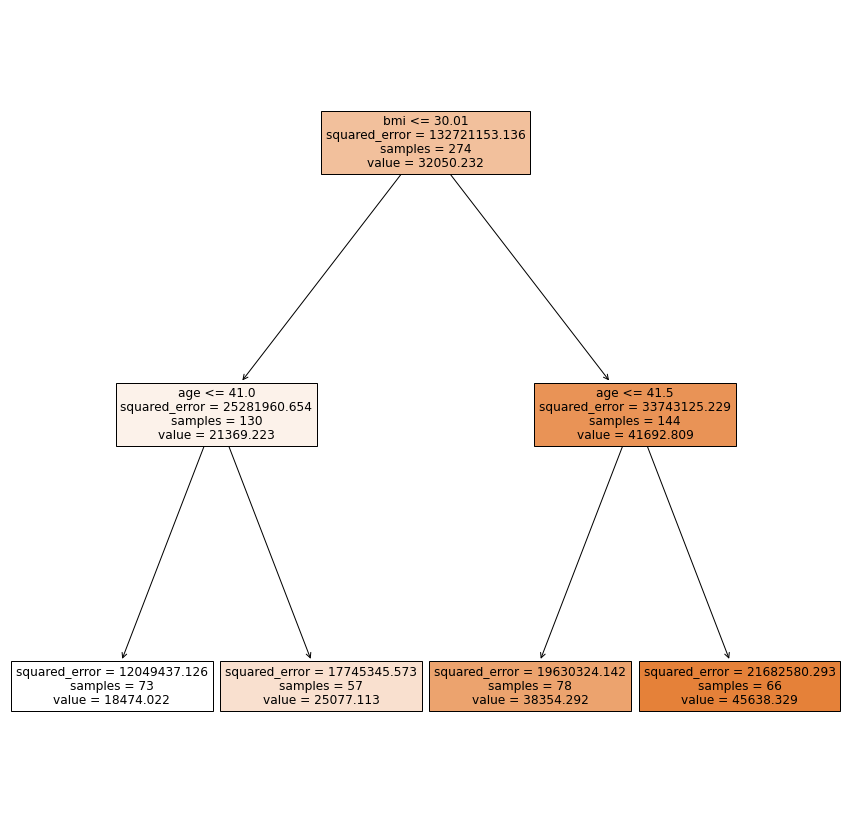

In [28]:
m = 2
dtree = tree.DecisionTreeRegressor(max_depth=m)

X = df_smokers.iloc[: , :4].copy()
X.sex = X.sex.apply(lambda x: 1 if x=="female" else 0)

y = df_smokers["charges"]
dtree.fit(X,y)

plt.figure(figsize=(15,15))
tree.plot_tree(dtree, filled=True, feature_names=X.columns)
plt.show()

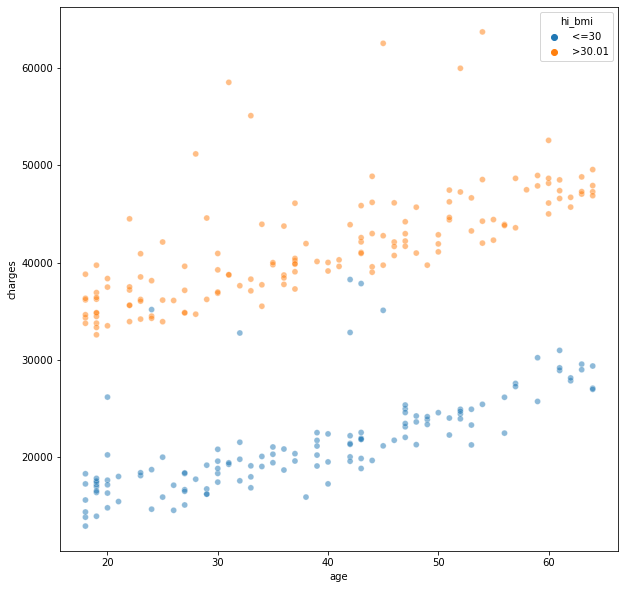

<Figure size 432x288 with 0 Axes>

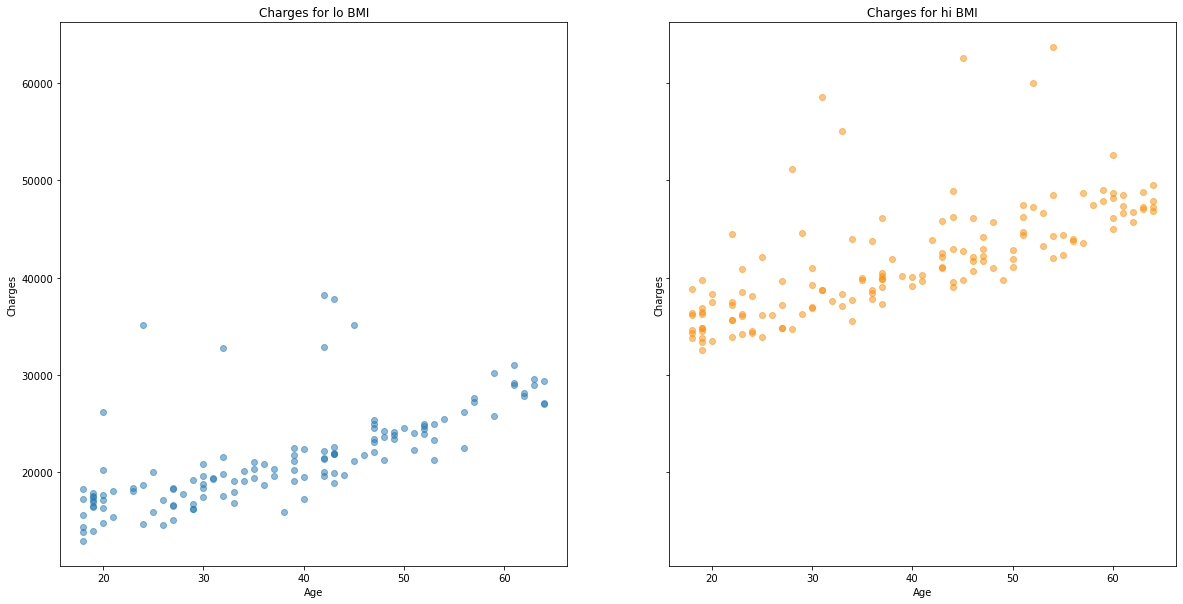

In [57]:
df_smokers["hi_bmi"] = df_smokers['bmi'].apply(lambda x: ">30.01" if x>30.01 else "<=30")

plt.figure(figsize=(10,10))
sns.scatterplot(x="age", y="charges", hue='hi_bmi', data=df_smokers, alpha=.5)

plt.show()
plt.clf()

hi_bmi = df_smokers[df_smokers.hi_bmi==">30.01"]
lo_bmi = df_smokers[df_smokers.hi_bmi=="<=30"]


f, (ax1,ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(20,10))

ax1.scatter(lo_bmi.age,lo_bmi.charges,alpha=0.5)
ax1.set_title("Charges for lo BMI")
ax1.set_xlabel("Age")
ax1.set_ylabel("Charges")

ax2.scatter(hi_bmi.age,hi_bmi.charges,alpha=0.5, color='darkorange')
ax2.set_title("Charges for hi BMI")
ax2.set_xlabel("Age")
ax2.set_ylabel("Charges")



plt.show()

# Linear Regression

Next we create Linear Regression models. They have two aims: model the prices in the dataset and forecast new prices. For the latter, we use a test-train split of the dataset and analyze its score.

In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [113]:
X = df.iloc[: , :6].copy()
X = pd.get_dummies(X, columns=["region"])
X.sex = X.sex.apply(lambda x: 1 if x=="female" else 0)
X["hi_bmi"] = X['bmi'].apply(lambda x: 1 if x>30.01 else 0)
y = df['charges']

model = LinearRegression()

# x_train, x_test, y_train, y_test = train_test_split(X,y,train_size=0.8)

model.fit(X,y)

print(f"Model Coefficients: \n{pd.Series(data=model.coef_ , index=X.columns)}")

Model Coefficients: 
age                   257.111947
sex                   153.697847
bmi                   142.822460
children              475.815950
smoker              23855.085096
region_northeast      550.015175
region_northwest      160.863138
region_southeast     -330.406565
region_southwest     -380.471748
hi_bmi               2947.869592
dtype: float64


Analyzing the coefficients we conclude that insurance costs were cheaper in the South region and way more expensive for the smoking population. For forecasting, though, we separate the smoker/non-smoker population in order to compare the model scores. Interestingly, for prediction matters, we infer that regions play no role at well.

### Forecasting Models: general, smoking and non-smoking populations

In [114]:
X = df.iloc[: , :5].copy()
X.sex = X.sex.apply(lambda x: 1 if x=="female" else 0)
X["hi_bmi"] = X['bmi'].apply(lambda x: 1 if x>30.01 else 0)

model = LinearRegression()

x_train, x_test, y_train, y_test = train_test_split(X,y,train_size=0.8)

model.fit(x_train, y_train)

print(f"Model Score: {model.score(x_test,y_test)}\n")
print(f"Model Coefficients: \n{pd.Series(data=model.coef_ , index=X.columns)}")





Model Score: 0.7611001506992019

Model Coefficients: 
age           249.238066
sex          -187.106859
bmi           150.060695
children      457.239434
smoker      23787.071969
hi_bmi       2789.275886
dtype: float64


In [115]:
X = df_smokers.iloc[: , :4].copy()
X.sex = X.sex.apply(lambda x: 1 if x=="female" else 0)
X["hi_bmi"] = X['bmi'].apply(lambda x: 1 if x>30.01 else 0)
y = df_smokers['charges']

model = LinearRegression()

x_train, x_test, y_train, y_test = train_test_split(X,y,train_size=0.8)

model.fit(x_train, y_train)

print(f"Model Score: {model.score(x_test,y_test)}\n")
print(f"Model Coefficients: \n{pd.Series(data=model.coef_ , index=X.columns)}")




Model Score: 0.9179962438396311

Model Coefficients: 
age           270.944302
sex           669.604236
bmi           449.543284
children      227.178317
hi_bmi      15400.283010
dtype: float64


In [124]:
X = df_no_smokers.iloc[: , :4].copy()
X.sex = X.sex.apply(lambda x: 1 if x=="female" else 0)
# X["hi_bmi"] = X['bmi'].apply(lambda x: 1 if x>30.01 else 0)
y = df_no_smokers['charges']

model = LinearRegression()

x_train, x_test, y_train, y_test = train_test_split(X,y,train_size=0.8)

model.fit(x_train, y_train)

print(f"Model Score: {model.score(x_test,y_test)}\n")
print(f"Model Coefficients: \n{pd.Series(data=model.coef_ , index=X.columns)}")





Model Score: 0.2914374282905835

Model Coefficients: 
age         272.587743
sex         761.553244
bmi          19.999499
children    595.050339
dtype: float64


We conclude that the linear model is highly precise to predict smokers' insurance, but left a lot in want for the non-smokers' charges. Such a behaviour should imply that there are not enough information for predicting the latter. 

### Comparing the influence of region in the charges costs

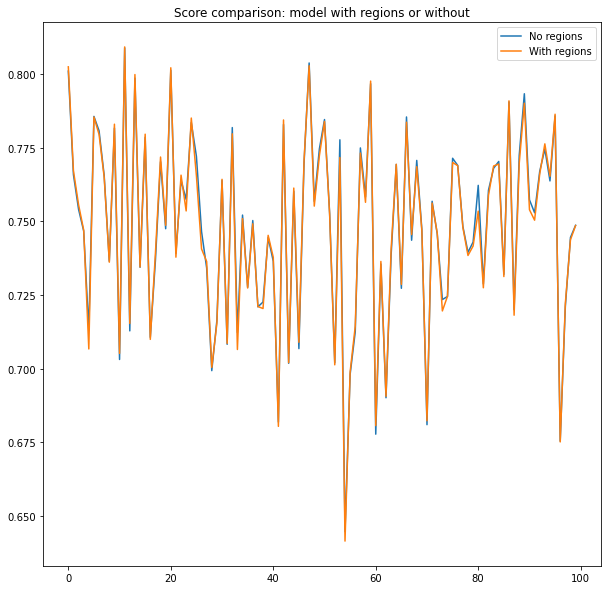

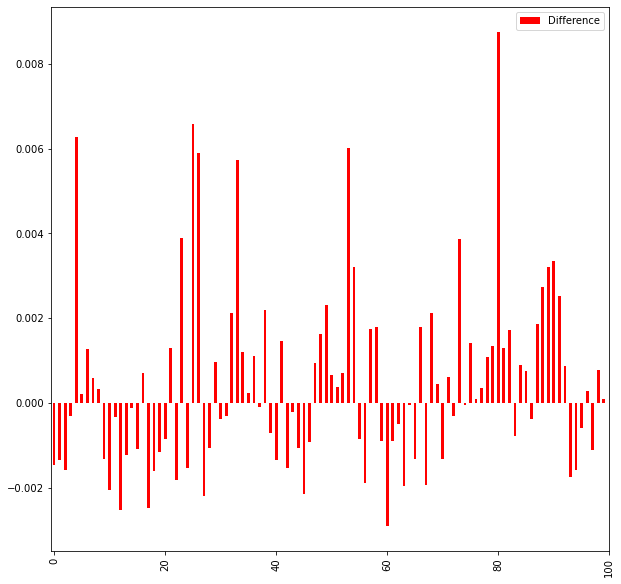

<Figure size 432x288 with 0 Axes>

In [160]:
X = df.iloc[: , :5].copy()
X.sex = X.sex.apply(lambda x: 1 if x=="female" else 0)
X["hi_bmi"] = X['bmi'].apply(lambda x: 1 if x>30.01 else 0)
y = df['charges']


score_nr = []

for rs in range(100):

    model = LinearRegression()

    x_train, x_test, y_train, y_test = train_test_split(X,y,train_size=0.8, random_state=rs)

    model.fit(x_train, y_train)
    score_nr.append(model.score(x_test,y_test))


X = df.iloc[: , :6].copy()
X = pd.get_dummies(X, columns=["region"])
X.sex = X.sex.apply(lambda x: 1 if x=="female" else 0)
X["hi_bmi"] = X['bmi'].apply(lambda x: 1 if x>30.01 else 0)
y = df['charges']

score_r = []

for rs in range(100):

    model = LinearRegression()

    x_train, x_test, y_train, y_test = train_test_split(X,y,train_size=0.8, random_state=rs)

    model.fit(x_train, y_train)
    score_r.append(model.score(x_test,y_test))



scores = pd.DataFrame([score_nr,score_r]).T
scores.columns = ["No regions", "With regions"]
scores.plot(title='Score comparison: model with regions or without', figsize=(10,10))


score_comparison = pd.DataFrame(score_nr)-pd.DataFrame(score_r)  
score_comparison.columns = ['Difference']
score_comparison.plot.bar(figsize=(10,10), color="red", xticks=range(0,101,20))
plt.show()
plt.clf()


    


<AxesSubplot:>

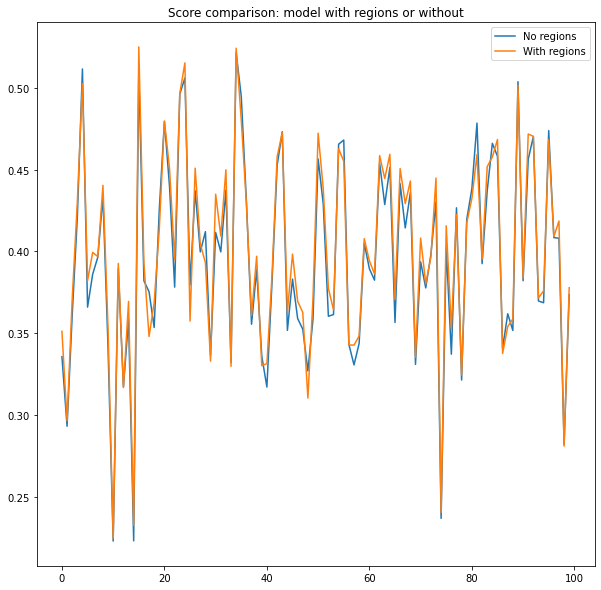

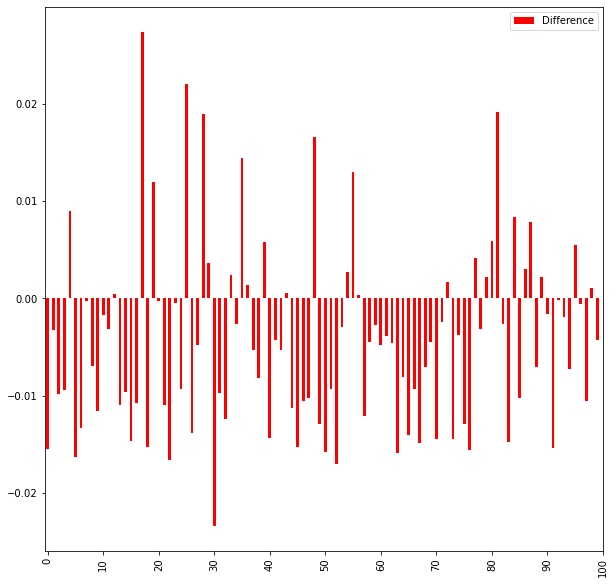

In [159]:
X = df_no_smokers.iloc[: , :4].copy()
X.sex = X.sex.apply(lambda x: 1 if x=="female" else 0)
X["hi_bmi"] = X['bmi'].apply(lambda x: 1 if x>30.01 else 0)
y = df_no_smokers['charges']


score_nr = []

for rs in range(100):

    model = LinearRegression()

    x_train, x_test, y_train, y_test = train_test_split(X,y,train_size=0.8, random_state=rs)

    model.fit(x_train, y_train)
    score_nr.append(model.score(x_test,y_test))


X = df_no_smokers.iloc[: , :5].copy()
X = pd.get_dummies(X, columns=["region"])
X.sex = X.sex.apply(lambda x: 1 if x=="female" else 0)
X["hi_bmi"] = X['bmi'].apply(lambda x: 1 if x>30.01 else 0)
y = df_no_smokers['charges']

score_r = []

for rs in range(100):

    model = LinearRegression()

    x_train, x_test, y_train, y_test = train_test_split(X,y,train_size=0.8, random_state=rs)

    model.fit(x_train, y_train)
    score_r.append(model.score(x_test,y_test))



    

    
scores = pd.DataFrame([score_nr,score_r]).T
scores.columns = ["No regions", "With regions"]
scores.plot(title='Score comparison: model with regions or without', figsize=(10,10))

score_comparison = pd.DataFrame(score_nr)-pd.DataFrame(score_r)  
score_comparison.columns = ['Difference']
score_comparison.plot.bar(figsize=(10,10), color="red", xticks=range(0,101,20))





We conclude that the predictions have about the same scores, the difference been $\pm 2$%, at most.

In [ ]:
# 